In [204]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from collections import Counter

### Estimate the proportion of ones in the population based in a data sample

In [143]:
data = '101110101'
ones = np.sum([1 for s in data if s=='1'])
zeros = np.sum([1 for s in data if s=='0'])
print(f'Data: {data}\n')
print(f'{len(data)} bit observations:')
print(f'  {ones} ones')
print(f'  {zeros} zeros')

Data: 101110101

9 bit observations:
  6 ones
  3 zeros


### Grid Approximation

In [329]:
sample_size = 10000

estimated_posterior = []
defined_grid = []
for grid_size in [5,20]:
    # Determine grid
    p_grid = np.linspace(0, 1, grid_size)
    # Estimate likelihood
    likelihood = []
    for p in p_grid:
        trial = np.random.binomial(n=9, p=p, size=sample_size)
        q = np.sum(np.where(trial==6,1,0))/sample_size
        likelihood.append(q)
    # Define prior
    prior = np.ones(grid_size)/grid_size
    # Compute posterior
    posterior = likelihood * prior
    # Stadarize posterior
    posterior = posterior / np.sum(posterior)
    defined_grid.append(p_grid)
    estimated_posterior.append(posterior)
    

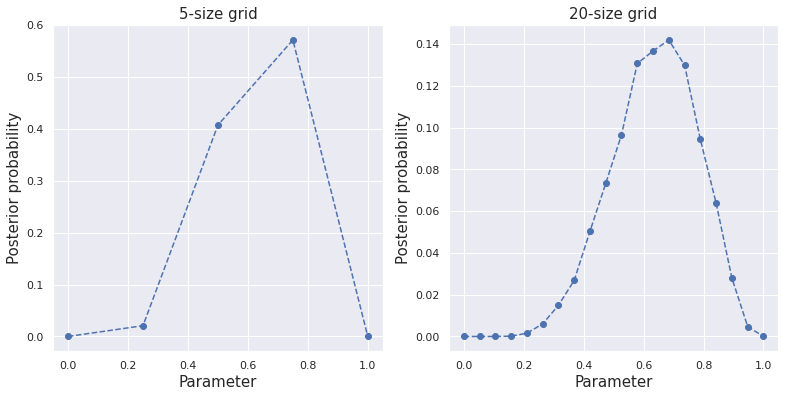

In [330]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

ax=ax1
ax.set_title(f'{len(defined_grid[0])}-size grid', fontsize=15)
ax.plot(defined_grid[0], estimated_posterior[0], marker='o', linestyle='--')
ax.set_xlabel('Parameter', fontsize=15)
ax.set_ylabel('Posterior probability', fontsize=15)

ax=ax2
ax.set_title(f'{len(defined_grid[1])}-size grid', fontsize=15)
ax.plot(defined_grid[1], estimated_posterior[1], marker='o', linestyle='--')
ax.set_xlabel('Parameter', fontsize=15)
ax.set_ylabel('Posterior probability', fontsize=15)


plt.show()

### MCMC

In [331]:
n_ones = 6
n_zeros = 3
p = [0.5]
for i in np.arange(1, 1000):
    p_new = np.random.normal(p[i-1], 0.1, size=1) # Centered on previos value
    if p_new < 0:
        p_new = np.abs(p_new)
    elif p_new > 1:
        p_new = 2-p_new
    
    p_new = p_new.item()
    
    trial = np.random.binomial(n=9, p=p[i-1], size=sample_size) # Likelihood given last estimation
    q0 = np.sum(np.where(trial==6,1,0))/sample_size

    trial = np.random.binomial(n=9, p=p_new, size=sample_size) # Likelihood given new estimation
    q1 = np.sum(np.where(trial==6,1,0))/sample_size
    
    r = np.random.uniform()
    if r < (q1/q0): # Compare the odds between new and last estimation
        p.append(p_new)
    else:
        p.append(p[i-1])
            

In [332]:
def bin_means(x, bins=10):
    buckets = pd.cut(pd.Series(x), bins=bins, labels=False)
    s_min, s_max = pd.Series(x).min(), pd.Series(x).max()
    values = np.linspace(s_min, s_max, bins+1)
    means = np.convolve(values, np.ones(2), 'valid') / 2
    
    df = pd.DataFrame.from_dict(Counter(pd.cut(pd.Series(p), bins=bins, labels=False)), orient='index').reset_index()
    df.columns = ['bin','count']
    df['freq'] = df['count']/df['count'].sum()
    df.sort_values('bin', inplace=True)
    df['center'] = np.round(means,2)
    
    return df

In [333]:
df = bin_means(p, bins=15)
df.head(1)

,bin,count,freq,center
10,0,10,0.01,0.24


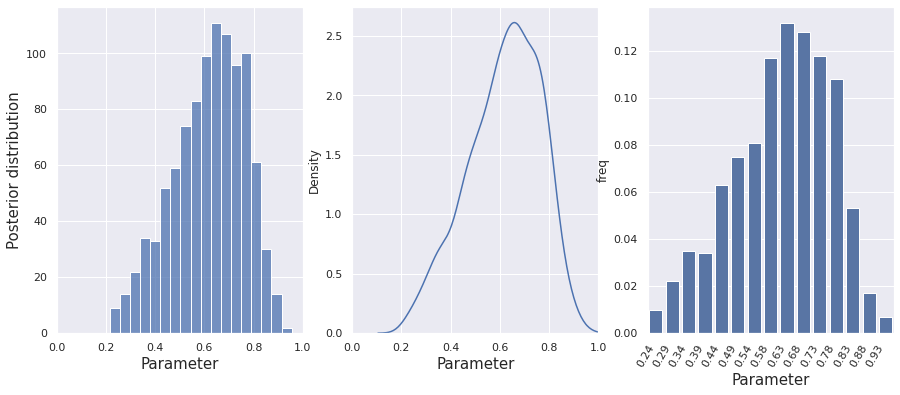

In [334]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

ax=ax1
sns.histplot(p, ax=ax)
ax.set_xlim(0,1)
ax.set_xlabel('Parameter', fontsize=15)
ax.set_ylabel('Posterior distribution', fontsize=15)

ax=ax2
sns.kdeplot(p, ax=ax)
ax.set_xlim(0,1)
ax.set_xlabel('Parameter', fontsize=15)

ax=ax3
sns.barplot(x=df.center, y=df.freq, color='b', ax=ax)
ax.set_xticklabels(df.center, rotation = 60, ha="right")
ax.set_xlabel('Parameter', fontsize=15)
#ax=ax1
#ax.set_title(f'{len(defined_grid[0])}-size grid', fontsize=15)
#ax.set_xlabel('Parameter', fontsize=15)
#ax.set_ylabel('Posterior probability', fontsize=15)

plt.show()